In [1]:

#@title Install Conda Colab
#@markdown This cell will restart kernel / session

!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [1]:
# DNABERT-2 merekomendasikan Python 3.8 (Sesuai README)
# Kita buat environment baru bernama 'dna_env'
!conda create -n dna_env python=3.8 -y

#@title Install Dependencies DNABERT-2 ke dalam 'dna_env'
#@markdown Script ini disesuaikan untuk **DNABERT-2** (PyTorch Modern, Transformers Terbaru, Einops).

import os

!git clone https://github.com/MAGICS-LAB/DNABERT_2.git

# 1. Definisikan lokasi PIP dan PYTHON milik environment baru
my_pip = "/usr/local/envs/dna_env/bin/pip"
my_python = "/usr/local/envs/dna_env/bin/python"

print(">>> Memulai instalasi dependencies untuk DNABERT-2 (Python 3.8)...")

# 2. Instalasi PyTorch (Versi Modern Kompatibel CUDA 11.8/12)
# DNABERT-2 membutuhkan PyTorch yang lebih baru dibanding DNABERT-1
!$my_pip install -q --no-warn-conflicts torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# 3. Instalasi Transformers & Dependencies Inti DNABERT-2
# Berbeda dengan versi 1, versi 2 butuh transformers terbaru
!$my_pip install -q --no-warn-conflicts transformers
!$my_pip install -q --no-warn-conflicts accelerate  # Wajib untuk training loop modern
!$my_pip install -q --no-warn-conflicts protobuf

# 4. Instalasi Library Khusus Arsitektur Model
# 'einops' wajib untuk DNABERT-2 (menangani dimensi tensor)
# 'sentencepiece' wajib untuk Tokenizer BPE
!$my_pip install -q --no-warn-conflicts einops
!$my_pip install -q --no-warn-conflicts sentencepiece

# 5. Instalasi Triton (Opsional tapi disarankan README untuk performa)
!$my_pip install -q --no-warn-conflicts triton

# 6. Instalasi Data Science & Evaluation
!$my_pip install -q --no-warn-conflicts scikit-learn
!$my_pip install -q --no-warn-conflicts pandas matplotlib
!$my_pip install -q --no-warn-conflicts scipy

print("\n>>> ✅ Instalasi ke dalam 'dna_env' selesai.")
print(f">>> Path Python DNABERT-2: {my_python}")

Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/dna_env

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       hda65f42_8         254 KB  conda-forge
    ca-certificates-2026.1.4   |       hbd8a1cb_0         143 KB  conda-forge
    icu-78.2                   |       h33c6efd_0        12.1 MB  conda-forge
    ld_impl_linux-64-2.45      |default_hbd61a6d_105         714 KB  conda-forge
    libffi-3.5.2               |       h9ec8514_0          56 KB  conda-forge
    libgcc-15.2.0              |      he0feb66_16        1018 KB  conda-forge
 

In [2]:
#@title 🧬 Generate Dummy Data (Format CSV)
#@markdown DNABERT-2 membaca **Raw DNA** (tanpa spasi/k-mer).
#@markdown Script ini membuat folder data dan file `train.csv`, `dev.csv`, `test.csv`.

import random
import os
import csv

# Konfigurasi
num_train = 200 #@param {type:"integer"}
num_dev = 50 #@param {type:"integer"}
seq_length = 100 #@param {type:"integer"}

# Lokasi Data
data_dir = "/content/data/my_experiment"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

def generate_csv(filename, n_samples, length):
    print(f"Generating {n_samples} samples -> {os.path.basename(filename)}")
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['sequence', 'label']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for _ in range(n_samples):
            # Generate Raw DNA (A, C, G, T)
            seq = "".join([random.choice("ACGT") for _ in range(length)])
            label = random.choice([0, 1])

            # Tulis ke CSV
            writer.writerow({'sequence': seq, 'label': label})

# Eksekusi
print(">>> Memulai Generasi Data...")
generate_csv(os.path.join(data_dir, "train.csv"), num_train, seq_length)
generate_csv(os.path.join(data_dir, "dev.csv"), num_dev, seq_length)
# Untuk dummy, test samakan dengan dev
generate_csv(os.path.join(data_dir, "test.csv"), num_dev, seq_length)

print(f"\n✅ Data siap di folder: {data_dir}")
print("Contoh data:")
!head -n 3 {data_dir}/train.csv

>>> Memulai Generasi Data...
Generating 200 samples -> train.csv
Generating 50 samples -> dev.csv
Generating 50 samples -> test.csv

✅ Data siap di folder: /content/data/my_experiment
Contoh data:
sequence,label
AAAATTTTAATTACGGTTATCGATAGGATTTGTACGACTCGTAAGGGTCAACGTGGACTGAAGTGTTCCGCGAGGAACTTATGCAGGGAGTACGGCGTCG,0
ATGGGAACAACCAACTCTTCAAGACCAGGCCTGGAGACGCTCCGGCGCACAGCTGGGATCATCCTCACAAACGGGAGATCCGGCACGACATACTATCAAT,0


In [32]:
#@title 📝 Overwrite 'train.py' (Versi Fix Config)
import os

# Pastikan folder tujuan ada
os.makedirs("/content/DNABERT_2/finetune", exist_ok=True)

# Menulis file train.py baru
code_content = """
import os
import csv
import copy
import json
import logging
from dataclasses import dataclass, field
from typing import Any, Optional, Dict, Sequence, Tuple, List, Union

import torch
import transformers
import sklearn
import numpy as np
from torch.utils.data import Dataset
from transformers import BertConfig  # <--- FIX: Import Explicit BertConfig

from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
)


@dataclass
class ModelArguments:
    model_name_or_path: Optional[str] = field(default="facebook/opt-125m")
    use_lora: bool = field(default=False, metadata={"help": "whether to use LoRA"})
    lora_r: int = field(default=8, metadata={"help": "hidden dimension for LoRA"})
    lora_alpha: int = field(default=32, metadata={"help": "alpha for LoRA"})
    lora_dropout: float = field(default=0.05, metadata={"help": "dropout rate for LoRA"})
    lora_target_modules: str = field(default="query,value", metadata={"help": "where to perform LoRA"})


@dataclass
class DataArguments:
    data_path: str = field(default=None, metadata={"help": "Path to the training data."})
    kmer: int = field(default=-1, metadata={"help": "k-mer for input sequence. -1 means not using k-mer."})


@dataclass
class TrainingArguments(transformers.TrainingArguments):
    cache_dir: Optional[str] = field(default=None)
    run_name: str = field(default="run")
    optim: str = field(default="adamw_torch")
    model_max_length: int = field(default=512, metadata={"help": "Maximum sequence length."})
    gradient_accumulation_steps: int = field(default=1)
    per_device_train_batch_size: int = field(default=1)
    per_device_eval_batch_size: int = field(default=1)
    num_train_epochs: int = field(default=1)
    fp16: bool = field(default=False)
    logging_steps: int = field(default=100)
    save_steps: int = field(default=100)
    eval_steps: int = field(default=100)
    evaluation_strategy: str = field(default="steps")
    warmup_steps: int = field(default=50)
    weight_decay: float = field(default=0.01)
    learning_rate: float = field(default=1e-4)
    save_total_limit: int = field(default=3)
    load_best_model_at_end: bool = field(default=True)
    output_dir: str = field(default="output")
    find_unused_parameters: bool = field(default=False)
    checkpointing: bool = field(default=False)
    dataloader_pin_memory: bool = field(default=False)
    eval_and_save_results: bool = field(default=True)
    save_model: bool = field(default=False)
    seed: int = field(default=42)


def safe_save_model_for_hf_trainer(trainer: transformers.Trainer, output_dir: str):
    state_dict = trainer.model.state_dict()
    if trainer.args.should_save:
        cpu_state_dict = {key: value.cpu() for key, value in state_dict.items()}
        del state_dict
        trainer._save(output_dir, state_dict=cpu_state_dict)  # noqa


def get_alter_of_dna_sequence(sequence: str):
    MAP = {"A": "T", "T": "A", "C": "G", "G": "C"}
    return "".join([MAP[c] for c in sequence])

def generate_kmer_str(sequence: str, k: int) -> str:
    return " ".join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])

def load_or_generate_kmer(data_path: str, texts: List[str], k: int) -> List[str]:
    kmer_path = data_path.replace(".csv", f"_{k}mer.json")
    if os.path.exists(kmer_path):
        logging.warning(f"Loading k-mer from {kmer_path}...")
        with open(kmer_path, "r") as f:
            kmer = json.load(f)
    else:
        logging.warning(f"Generating k-mer...")
        kmer = [generate_kmer_str(text, k) for text in texts]
        with open(kmer_path, "w") as f:
            logging.warning(f"Saving k-mer to {kmer_path}...")
            json.dump(kmer, f)

    return kmer

class SupervisedDataset(Dataset):
    def __init__(self, data_path: str, tokenizer: transformers.PreTrainedTokenizer, kmer: int = -1):
        super(SupervisedDataset, self).__init__()
        with open(data_path, "r") as f:
            data = list(csv.reader(f))[1:]
        if len(data[0]) == 2:
            logging.warning("Perform single sequence classification...")
            texts = [d[0] for d in data]
            labels = [int(d[1]) for d in data]
        elif len(data[0]) == 3:
            logging.warning("Perform sequence-pair classification...")
            texts = [[d[0], d[1]] for d in data]
            labels = [int(d[2]) for d in data]
        else:
            raise ValueError("Data format not supported.")

        if kmer != -1:
            if torch.distributed.is_initialized() and torch.distributed.get_rank() not in [0, -1]:
                torch.distributed.barrier()

            logging.warning(f"Using {kmer}-mer as input...")
            texts = load_or_generate_kmer(data_path, texts, kmer)

            if torch.distributed.is_initialized() and torch.distributed.get_rank() == 0:
                torch.distributed.barrier()

        output = tokenizer(
            texts,
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=True,
        )

        self.input_ids = output["input_ids"]
        self.attention_mask = output["attention_mask"]
        self.labels = labels
        self.num_labels = len(set(labels))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])


@dataclass
class DataCollatorForSupervisedDataset(object):
    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.Tensor(labels).long()
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

def calculate_metric_with_sklearn(predictions: np.ndarray, labels: np.ndarray):
    valid_mask = labels != -100
    valid_predictions = predictions[valid_mask]
    valid_labels = labels[valid_mask]
    return {
        "accuracy": sklearn.metrics.accuracy_score(valid_labels, valid_predictions),
        "f1": sklearn.metrics.f1_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
        "matthews_correlation": sklearn.metrics.matthews_corrcoef(
            valid_labels, valid_predictions
        ),
        "precision": sklearn.metrics.precision_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
        "recall": sklearn.metrics.recall_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
    }

def preprocess_logits_for_metrics(logits:Union[torch.Tensor, Tuple[torch.Tensor, Any]], _):
    if isinstance(logits, tuple):
        logits = logits[0]
    if logits.ndim == 3:
        logits = logits.reshape(-1, logits.shape[-1])
    return torch.argmax(logits, dim=-1)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return calculate_metric_with_sklearn(predictions, labels)

def train():
    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    model_args, data_args, training_args = parser.parse_args_into_dataclasses()

    # load tokenizer
    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
        cache_dir=training_args.cache_dir,
        model_max_length=training_args.model_max_length,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

    if "InstaDeepAI" in model_args.model_name_or_path:
        tokenizer.eos_token = tokenizer.pad_token

    # define datasets and data collator
    train_dataset = SupervisedDataset(tokenizer=tokenizer,
                                      data_path=os.path.join(data_args.data_path, "train.csv"),
                                      kmer=data_args.kmer)
    val_dataset = SupervisedDataset(tokenizer=tokenizer,
                                     data_path=os.path.join(data_args.data_path, "dev.csv"),
                                     kmer=data_args.kmer)
    test_dataset = SupervisedDataset(tokenizer=tokenizer,
                                     data_path=os.path.join(data_args.data_path, "test.csv"),
                                     kmer=data_args.kmer)
    data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

    # --- BAGIAN INI DIPERBAIKI (FIX CONFIG MISMATCH) ---
    print("--> Loading Model with Explicit BertConfig...")

    # 1. Kita load config secara eksplisit menggunakan BertConfig
    config = BertConfig.from_pretrained(
        model_args.model_name_or_path,
        num_labels=train_dataset.num_labels, # Mengambil jumlah label dari dataset
    )

    # 2. Kita masukkan config tersebut ke AutoModel
    model = transformers.AutoModelForSequenceClassification.from_pretrained(
        model_args.model_name_or_path,
        config=config, # Pass config yang sudah kita buat
        cache_dir=training_args.cache_dir,
        trust_remote_code=True,
        ignore_mismatched_sizes=True # Penting untuk finetuning beda label
    )
    # ----------------------------------------------------

    # configure LoRA
    if model_args.use_lora:
        lora_config = LoraConfig(
            r=model_args.lora_r,
            lora_alpha=model_args.lora_alpha,
            target_modules=list(model_args.lora_target_modules.split(",")),
            lora_dropout=model_args.lora_dropout,
            bias="none",
            task_type="SEQ_CLS",
            inference_mode=False,
        )
        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

    # define trainer
    trainer = transformers.Trainer(model=model,
                                   tokenizer=tokenizer,
                                   args=training_args,
                                   preprocess_logits_for_metrics=preprocess_logits_for_metrics,
                                   compute_metrics=compute_metrics,
                                   train_dataset=train_dataset,
                                   eval_dataset=val_dataset,
                                   data_collator=data_collator)
    trainer.train()

    if training_args.save_model:
        trainer.save_state()
        safe_save_model_for_hf_trainer(trainer=trainer, output_dir=training_args.output_dir)

    if training_args.eval_and_save_results:
        results_path = os.path.join(training_args.output_dir, "results", training_args.run_name)
        results = trainer.evaluate(eval_dataset=test_dataset)
        os.makedirs(results_path, exist_ok=True)
        with open(os.path.join(results_path, "eval_results.json"), "w") as f:
            json.dump(results, f)

if __name__ == "__main__":
    train()
"""

with open("/content/DNABERT_2/finetune/train.py", "w") as f:
    f.write(code_content)

print("✅ File 'train.py' berhasil diperbarui dengan FIX Config.")

✅ File 'train.py' berhasil diperbarui dengan FIX Config.


In [30]:
#@title 🔧 Update Library & Patch Model (Safety Check)
import os
import shutil
from huggingface_hub import snapshot_download

# 1. Update Library (wajib agar tidak ada error dispatch_batches)
!/usr/local/envs/dna_env/bin/pip install -U --no-warn-conflicts accelerate transformers

# 2. Siapkan Model Lokal (wajib agar tidak ada error Flash Attention)
local_model_path = "/content/dnabert2_local"

# Jika belum ada, download ulang
if not os.path.exists(local_model_path):
    print(f">>> Mendownload DNABERT-2 ke: {local_model_path}...")
    snapshot_download(repo_id="zhihan1996/DNABERT-2-117M", local_dir=local_model_path, local_dir_use_symlinks=False)

# Patching file 'bert_layers.py' (Cara Global - Paling Aman)
bert_layers_path = os.path.join(local_model_path, "bert_layers.py")
print(f">>> Memastikan Patch Flash Attention di: {bert_layers_path}...")

with open(bert_layers_path, "r") as f:
    lines = f.readlines()

new_lines = []
inserted_var = False
has_been_patched = False

for line in lines:
    if "flash_attn_qkvpacked_func = None" in line:
        has_been_patched = True

    # Comment out import yang bermasalah
    if "flash_attn_triton" in line and not line.strip().startswith("#"):
        new_lines.append(f"# {line}")
    else:
        new_lines.append(line)

    # Sisipkan variabel disable di atas
    if "import torch" in line and not inserted_var and not has_been_patched:
        new_lines.append("flash_attn_qkvpacked_func = None\n")
        inserted_var = True

with open(bert_layers_path, "w") as f:
    f.writelines(new_lines)

# Bersihkan Cache HuggingFace (Agar patch terbaca)
cache_dir = "/root/.cache/huggingface/modules/transformers_modules"
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)

print("✅ Library Updated & Model Patched.")

>>> Memastikan Patch Flash Attention di: /content/dnabert2_local/bert_layers.py...
✅ Library Updated & Model Patched.


In [34]:
#@title 🚑 FIX TOTAL: Reset Model, Safe Patch, & Run
import os
import shutil
from huggingface_hub import snapshot_download

# --- BAGIAN 1: BERSIH-BERSIH (RESET) ---
local_model_path = "/content/dnabert2_local"
hf_cache_dir = "/root/.cache/huggingface/modules/transformers_modules"

print(">>> 1. Menghapus file model yang rusak (Indentation Error)...")
if os.path.exists(local_model_path):
    shutil.rmtree(local_model_path)

if os.path.exists(hf_cache_dir):
    print(">>>    Membersihkan cache internal HuggingFace...")
    shutil.rmtree(hf_cache_dir)

# --- BAGIAN 2: DOWNLOAD BARU ---
print("\n>>> 2. Mendownload ulang DNABERT-2 (Fresh Copy)...")
snapshot_download(
    repo_id="zhihan1996/DNABERT-2-117M",
    local_dir=local_model_path,
    local_dir_use_symlinks=False
)

# --- BAGIAN 3: SAFE PATCH (ANTI-INDENTATION ERROR) ---
bert_layers_path = os.path.join(local_model_path, "bert_layers.py")
print(f"\n>>> 3. Menerapkan Patch Aman ke: {bert_layers_path}...")

with open(bert_layers_path, "r") as f:
    lines = f.readlines()

with open(bert_layers_path, "w") as f:
    for line in lines:
        # Kita cari baris yang mencoba import Triton / Flash Attention
        if "from .flash_attn_triton import" in line:
            # Ambil spasi/indentasi asli agar struktur Python tidak rusak
            indent = line[:len(line) - len(line.lstrip())]

            # GANTI baris import dengan assignment variabel kosong.
            # Ini valid syntax di dalam blok 'try', jadi tidak akan error indentation.
            f.write(f"{indent}flash_attn_qkvpacked_func = None\n")
            f.write(f"{indent}flash_attn_func = None\n")
            print("       -> Import Flash Attention diganti dengan Variabel None (Aman).")
        else:
            f.write(line)

print("✅ Patch Selesai. Struktur kode aman.")

# --- BAGIAN 4: RUN TRAINING ---
print("\n>>> 4. Memulai Training DNABERT-2 (Final)...")

my_python = "/usr/local/envs/dna_env/bin/python"
train_script = "/content/DNABERT_2/finetune/train.py"
output_dir = "output/dnabert2_result"

# Pastikan Environment Variables ter-set
os.environ["DATA_PATH"] = "/content/data/my_experiment"
os.environ["OUTPUT_DIR"] = output_dir

cmd = f"""
{my_python} {train_script} \
    --model_name_or_path {local_model_path} \
    --data_path  {os.environ['DATA_PATH']} \
    --kmer -1 \
    --run_name DNABERT2_FinalRun \
    --model_max_length 100 \
    --per_device_train_batch_size 8 \
    --per_device_eval_batch_size 16 \
    --gradient_accumulation_steps 1 \
    --learning_rate 3e-5 \
    --num_train_epochs 3 \
    --fp16 \
    --save_steps 50 \
    --output_dir {output_dir} \
    --evaluation_strategy steps \
    --eval_steps 50 \
    --warmup_steps 20 \
    --logging_steps 10 \
    --overwrite_output_dir True \
    --find_unused_parameters False \
    --save_model True
"""

!{cmd}

print(f"\n✅ Selesai! Cek folder output: {output_dir}")

>>> 1. Menghapus file model yang rusak (Indentation Error)...
>>>    Membersihkan cache internal HuggingFace...

>>> 2. Mendownload ulang DNABERT-2 (Fresh Copy)...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


>>> 3. Menerapkan Patch Aman ke: /content/dnabert2_local/bert_layers.py...
       -> Import Flash Attention diganti dengan Variabel None (Aman).
✅ Patch Selesai. Struktur kode aman.

>>> 4. Memulai Training DNABERT-2 (Final)...
/usr/local/envs/dna_env/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
--> Loading Model with Explicit BertConfig...
/root/.cache/huggingface/modules/transformers_modules/dnabert2_local/bert_layers.py:127: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertForSequenceC

In [43]:
#@title 🚑 FIX FINAL: Copy All Python Scripts (*.py)
import shutil
import os
import glob

# Folder Sumber (Download-an awal yang sehat)
source_dir = "/content/dnabert2_local"
# Folder Tujuan (Hasil Training yang 'pincang')
target_dir = "output/dnabert2_result"

print(f">>> Menyalin semua script otak (.py) dari {source_dir} ke {target_dir}...")

# Cari semua file berakhiran .py
py_files = glob.glob(os.path.join(source_dir, "*.py"))

copied_count = 0
for file_path in py_files:
    file_name = os.path.basename(file_path)
    dest_path = os.path.join(target_dir, file_name)

    # Copy file
    shutil.copy2(file_path, dest_path)
    print(f"  ✅ Copied: {file_name}")
    copied_count += 1

if copied_count > 0:
    print(f"\n🎉 Berhasil menyalin {copied_count} file Python!")
    print("Sekarang folder output dijamin lengkap.")
else:
    print("❌ Aneh, tidak ditemukan file .py di folder sumber. Cek apakah folder source benar?")

>>> Menyalin semua script otak (.py) dari /content/dnabert2_local ke output/dnabert2_result...
  ✅ Copied: bert_layers.py
  ✅ Copied: flash_attn_triton.py
  ✅ Copied: bert_padding.py
  ✅ Copied: configuration_bert.py

🎉 Berhasil menyalin 4 file Python!
Sekarang folder output dijamin lengkap.


In [44]:
#@title 🔮 Inference Check (The Real Final)
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

model_path = "output/dnabert2_result"
print(f">>> Loading model dari: {model_path}")

try:
    # Load Tokenizer & Model
    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, trust_remote_code=True)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    print(f"✅ SUKSES! Pipeline Model Siap digunakan di {device}.")
    print("="*40)

    # --- INPUT DATA DNA BARU DI SINI ---
    sequences = [
        "ACGTACGTACGTACGTACGTACGTACGTACGT", # Seq 1
        "GGGGTTTTAAAACCCCGGGGTTTTAAAACCCC", # Seq 2
    ]

    for i, seq in enumerate(sequences):
        inputs = tokenizer(seq, return_tensors="pt", padding=True, truncation=True, max_length=100)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
            pred_class = np.argmax(probs)

        print(f"🧬 Sequence {i+1}: {seq[:10]}...")
        print(f"   📊 Confidence: {probs}")
        print(f"   🎯 Prediksi: KELAS {pred_class}")
        print("-" * 30)

except Exception as e:
    print(f"\n❌ Masih error: {e}")

You are using a model of type bert to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


>>> Loading model dari: output/dnabert2_result


/root/.cache/huggingface/modules/transformers_modules/dnabert2_result/bert_layers.py:127: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


✅ SUKSES! Pipeline Model Siap digunakan di cuda.
🧬 Sequence 1: ACGTACGTAC...
   📊 Confidence: [0.47716114 0.52283883]
   🎯 Prediksi: KELAS 1
------------------------------
🧬 Sequence 2: GGGGTTTTAA...
   📊 Confidence: [0.51029843 0.4897016 ]
   🎯 Prediksi: KELAS 0
------------------------------


>>> Menghitung embedding untuk 50 data...
✅ Berhasil! Embedding Shape: (50, 76800)


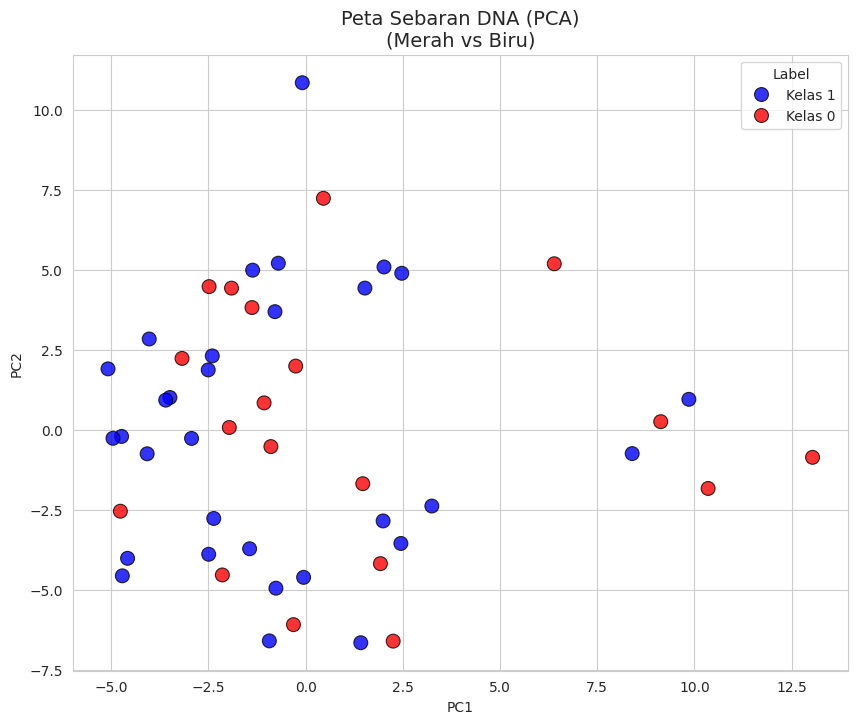

In [47]:
#@title 📊 Visualisasi Embedding (PCA) - Fix Dimensi Otomatis
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import pandas as pd
import numpy as np
import seaborn as sns

# 1. Load Data Test
df = pd.read_csv("/content/data/my_experiment/test.csv")
df['sequence'] = df['sequence'].astype(str)
df = df.dropna(subset=['sequence', 'label'])

# Ambil 50 sampel saja
df_sample = df.head(50)
sequences = df_sample['sequence'].tolist()
labels = df_sample['label'].tolist()

embeddings = []
valid_labels = []

print(f">>> Menghitung embedding untuk {len(sequences)} data...")
model.eval()

with torch.no_grad():
    for i, seq in enumerate(sequences):
        try:
            inputs = tokenizer(seq, return_tensors="pt", padding="max_length", truncation=True, max_length=100)
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

            outputs = model(**inputs, output_hidden_states=True)

            # Ambil hidden state terakhir
            # Dalam DNABERT-2 custom, ini bisa jadi 2D atau 3D tergantung config
            last_hidden = outputs.hidden_states[-1]

            # --- LOGIKA ADAPTIF (FIX ERROR) ---
            if len(last_hidden.shape) == 3:
                # Kasus 3D: [Batch, Seq_Len, Hidden] -> Kita ambil token pertama (CLS)
                # print("Mode 3D detected")
                vec = last_hidden[:, 0, :].cpu().numpy().flatten()
            elif len(last_hidden.shape) == 2:
                # Kasus 2D: [Batch, Hidden] -> Ini sudah berupa embedding vector!
                # print("Mode 2D detected")
                vec = last_hidden.cpu().numpy().flatten()
            else:
                # Fallback aneh
                print(f"⚠️ Shape aneh: {last_hidden.shape}, skip.")
                continue

            embeddings.append(vec)
            valid_labels.append(labels[i])

        except Exception as e:
            print(f"⚠️ Error pada data ke-{i}: {e}")

# Cek apakah ada data yang berhasil
if len(embeddings) == 0:
    print("❌ Masih gagal mendapatkan embedding. Cek model.")
else:
    # Konversi ke Numpy
    X = np.array(embeddings)
    y = np.array(valid_labels)
    print(f"✅ Berhasil! Embedding Shape: {X.shape}")

    # 2. PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)

    # 3. Plotting
    plt.figure(figsize=(10, 8))
    sns.set_style("whitegrid")

    plot_df = pd.DataFrame({
        'PC1': reduced[:, 0],
        'PC2': reduced[:, 1],
        'Label': [f'Kelas {l}' for l in y]
    })

    sns.scatterplot(
        data=plot_df, x='PC1', y='PC2', hue='Label',
        palette=['blue', 'red'], s=100, alpha=0.8, edgecolor='k'
    )

    plt.title(f"Peta Sebaran DNA (PCA)\n(Merah vs Biru)", fontsize=14)
    plt.show()